<h1> LOGISTIC REGRESSION:


<p style='font-size:18px'><b> Description </b></p>
<p>

Models like logistic regression or Naive Bayes algorithm, predict the probabilities of observing some outcomes. In standard binary regression scenario the models give you probability of observing the "success" category. In multinomial case, the models return probabilities of observing each of the outcomes. Log probabilities are simply natural logarithms of the predicted probabilities. <p>
    Logistic regression is a classsification technique. The algorithm is very simple & elegant. The decision surfave here is a line/a plane which seperates my positive and my negative classes <p> <p>
        
        $$W^*=argmax{\sum_{i=0}^n y_i(W^T*x_i)}$$ 


<br />
</p>

<h1>1.LOADING THE DATA </h1>


In [24]:
import os
os.getcwd()
os.chdir('/home/a4ankan/aMAZON fINAL WORK/amazon fine food')
os.getcwd()

'/home/a4ankan/aMAZON fINAL WORK/amazon fine food'

In [62]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import datetime



# it connects my code with the sql database
con = sqlite3.connect('database.sqlite') 



#Writting a query; 'con' is the link
# Here, I am saying that 'slelct (*) from reviews which are not equal to 3'.
#Just take the reviews which are 1,2,4 or 5.



filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) #filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3



# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return -1
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
filtered_data.sort_values('Time',inplace=True) 

print(filtered_data.shape) #The score coloumn becomesb positive / negative
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."


<h2>1.2 Data Cleansing : deduplication </h2>


In [64]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)

#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

(364173, 10)


69.25890143662969

In [65]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)



display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [66]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


 1    307061
-1     57110
Name: Score, dtype: int64

In [67]:
filtered_data[['Score','Text', 'Time']].head()

,Score,Text,Time
138706,1,this witty little book makes my son laugh at l...,939340800
138683,1,I can remember seeing the show when it aired o...,940809600
417839,1,Beetlejuice is a well written movie ..... ever...,944092800
417859,1,"A twist of rumplestiskin captured on film, sta...",944438400
212472,1,"A twist of rumplestiskin captured on film, sta...",944438400


<h3> 1.2.1 How to convert Text to Vector?? Text Preprocessing: Stemming, stop-word removal and Lemmatization. </h3>



In [68]:
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

1
Summary:  A young boy describes the usefulness of chicken soup with rice for each month of the year.<br /><br />Evaluation:  With Sendak's creative repetitious and rhythmic words, children will enjoy and learn to read the story of a boy who loves chicken soup with rice!  Through Sendak's catchy story, children will also learn the months of the year, as well as what seasons go with what month! They learn to identify ice-skating and snowmen in the winter; strong wind in March; birds and flowers in the spring; swimming and hot temperatures in the summer; and finally different holidays throughout the year. Such as Halloween in October, and Christmas in December.<br /><br />Sendak's simple three colored crayon-like drawings are a perfect addition to his educational and entertaining story.<br /><br />A great activity that you can do with this book is to have children draw their own illustrations for each month of the year.  Afterwards you can bind the pages together so the children can cre

In [69]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'while', 'some', 'until', 'will', 'yourself', 'with', 's', 'under', 'can', "don't", 'doesn', 'has', 'wouldn', 'hasn', 'being', 'out', 'needn', 'that', 'who', 'if', 'these', 'it', "wouldn't", 'more', 'during', 'y', 'shouldn', 'on', 'the', "haven't", 'herself', 'other', "isn't", 'been', 'was', 'should', 'don', 'be', "you've", 'them', 'is', 'down', 'does', "shouldn't", 'how', 'haven', 'or', 'about', 've', 'were', 'then', 'you', "hasn't", 'and', 'my', 'its', "wasn't", 'their', 'we', 'where', 'not', 'nor', 'over', "mightn't", "weren't", 'yourselves', 'had', 'from', 'below', 're', 'me', 'doing', 'most', 'aren', "aren't", 'an', 'do', 'she', 'her', 'before', "didn't", 'between', 'above', 'which', 'ma', 'for', 'theirs', 'only', "you're", 'o', 'they', 'as', 'to', 'weren', 'this', 'why', 'your', "it's", 'him', 'here', 'hers', 'such', 'once', 'few', "doesn't", 'mustn', 'shan', 'himself', 'a', 't', 'any', 'at', 'after', "you'll", 'each', 'through', 'll', 'hadn', "she's", 'our', 'didn', 'he', "shou

In [70]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1
    

In [71]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
final.sort_values('Time',inplace=True) 

In [72]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase


i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Summary'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [73]:
final['Summary']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['Summary']=final['Summary'].str.decode("utf-8")

In [74]:
final['New'] = final['Summary'] + final['CleanedText']

In [75]:
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,New
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,everi book educ,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educwitti littl book make son laugh...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,whole seri great way spend time child,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time childrememb se...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,entertainingl funni,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funnibeetlejuic well written mov...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,modern day fairi tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi taletwist rumplestiskin captu...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,fantast,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantastbeetlejuic excel funni movi keaton hila...


In [76]:

# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [77]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,New
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,everi book educ,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educwitti littl book make son laugh...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,whole seri great way spend time child,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time childrememb se...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,entertainingl funni,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funnibeetlejuic well written mov...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,modern day fairi tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi taletwist rumplestiskin captu...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,fantast,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantastbeetlejuic excel funni movi keaton hila...


In [177]:
final = final.sample(n = 300000, replace = True) # Sampling 100k rows 
final = pd.DataFrame(final)
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,New
234115,254008,B00496V7VM,A3A7OPK9EVIDN2,"Christine ""carob lover""",2,2,1,1301184000,better refriger,I have been using this product for about 5 yea...,use product year find great substitut milk how...,better refrigeruse product year find great sub...
460702,498214,B0030VBPN2,A2LKXYAP5TQ037,thegirlwhopaintedtrees,0,0,1,1313625600,great finicki eater,My 2 and 4 yr old drink these in the car. It'...,old drink car great snack toddler vitamin mine...,great finicki eaterold drink car great snack t...
392802,424751,B0051WAJ5I,A3U5L36IR8M1PI,Janice Wright,0,0,1,1332633600,boston cooki vegan assort flavor,I am vegan and ordered these cookies wanting o...,vegan order cooki want choc howev came asst fl...,boston cooki vegan assort flavorvegan order co...
285277,309042,B000JSLYSU,AY12DBB0U420B,Gary Peterson,0,0,1,1332115200,mmmmmm good,"My wife is from Europe (Russia mainly, but she...",wife europ russia main shes also live england ...,mmmmmm goodwife europ russia main shes also li...
504157,545159,B001SB4DLC,A2BGMB2GDUMD9,Linda S. Marks,0,0,1,1319414400,great brisket marinad,We purchased the last two bottles Claude's Bri...,purchas last two bottl claud brisket marinad c...,great brisket marinadpurchas last two bottl cl...


In [178]:
X = final['New']
X.shape


(300000,)

In [179]:
Y = final['Score']
Y.head()

234115    1
460702    1
392802    1
285277    1
504157    1
Name: Score, dtype: int64

In [180]:
Y.shape

(300000,)

In [82]:
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
import warnings
from sklearn import preprocessing
warnings.filterwarnings("ignore")

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn import preprocessing


In [181]:
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=0.3, random_state=0)

print("Train Data Size: ",X_train.shape)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (210000,)
Test Data Size:  (90000,)


In [182]:
print("Train Data Size: ",Y_train.shape)
print("Test Data Size: ",Y_test.shape)

Train Data Size:  (210000,)
Test Data Size:  (90000,)


<h1>2.Bag Of Words (BoW) : </h1>


Bag of Words constructs a dictionary of all the words in the document. A corpous is defined as a set of documents/reviews.
It converts all the words in the document into a vector each word having a different dimension. Each cell in the vector corresponds to the no of times a word occurs in the document.
 Similar texts result in closer distances between two vectors. Although BoW has its own limitations.


In [183]:
#BoW

count_vect = CountVectorizer() #in scikit-learn
X_train_bow = count_vect.fit_transform(X_train) #
X_test_bow = count_vect.transform(X_test)#
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words ", X_train_bow.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (210000, 91213)
the number of unique words  91213


In [184]:
from sklearn import preprocessing


In [185]:
X_train_bow = preprocessing.normalize(X_train_bow)
X_train_bow

<210000x91213 sparse matrix of type '<class 'numpy.float64'>'
	with 6852231 stored elements in Compressed Sparse Row format>

In [186]:


from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train_bow):
    print(X_train_bow[train].shape, X_train_bow[cv].shape)


(19100, 91213) (19090, 91213)
(38190, 91213) (19090, 91213)
(57280, 91213) (19090, 91213)
(76370, 91213) (19090, 91213)
(95460, 91213) (19090, 91213)
(114550, 91213) (19090, 91213)
(133640, 91213) (19090, 91213)
(152730, 91213) (19090, 91213)
(171820, 91213) (19090, 91213)
(190910, 91213) (19090, 91213)


In [187]:
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from datetime import datetime

<h3> 2.1 Here we find the best accuraccy, best hyper parameter, best estimator and the best score with 'GridSearchCV' for BoW </h3>

In [190]:


start = datetime.now()

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

tuned_parameters = { 'C': [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4],
              'penalty':['l1','l2']}
model = GridSearchCV(LogisticRegression(n_jobs = -1), tuned_parameters, cv = tscv,
                     scoring = 'f1', n_jobs = -1)
model.fit(X_train_bow, Y_train)
Y_pred = model.predict(X_test_bow)
print(model.best_estimator_)
print('Score with f1 is :',model.score(X_test_bow, Y_test))
print("Best HyperParameter for f1 scoring: ",model.best_params_)
print("Best Accuracy for f1 scoring: %.2f%%"%(model.best_score_*100))

print('------------------------------------------------------------------------\n')

print('------------------------------------------------------------------------')



model_roc_auc = GridSearchCV(LogisticRegression(n_jobs = -1), tuned_parameters, cv = tscv,
                     scoring = 'roc_auc', n_jobs = -1)
model_roc_auc.fit(X_train_bow, Y_train)
Y_pred = model_roc_auc.predict(X_test_bow)
print(model_roc_auc.best_estimator_)
print('Score with roc_auc is :',model_roc_auc.score(X_test_bow, Y_test))
print("Best HyperParameter for roc_auc: ",model_roc_auc.best_params_)
print("Best Accuracy for roc_auc: %.2f%%"%(model_roc_auc.best_score_*100))

print('------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Score with f1 is : 0.992472755870127
Best HyperParameter for f1 scoring:  {'C': 100, 'penalty': 'l1'}
Best Accuracy for f1 scoring: 97.80%
------------------------------------------------------------------------

------------------------------------------------------------------------
LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Score with roc_auc is : 0.9911484653174248
Best HyperParameter for roc_auc:  {'C': 100, 'penalty': 'l2'}
Best Accuracy for roc_auc: 97.66%
-------------------------------------------

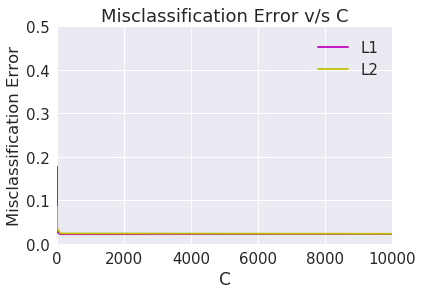

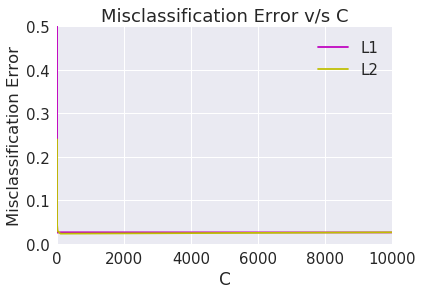

In [191]:
def plot_error_vs_c(model):
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    for a in model.grid_scores_:
        if (a[0]['penalty']) == 'l1':
            y1.append(1-a[1])
            x1.append(a[0]['C'])
        else:
            y2.append(1-a[1])
            x2.append(a[0]['C'])
    plt.xlim(10**-4,10**4) # limiting Xaxis to range of tuned parameters
    plt.ylim(0,0.5) #assuming that there would be maximum 50% error
    plt.xlabel("C",fontsize=17)
    plt.ylabel("Misclassification Error")
    plt.title('Misclassification Error v/s C')
    plt.plot(x1,y1,'m',label="L1")
    plt.plot(x2,y2,'y',label="L2")
    plt.legend()
    plt.show()
    
    

plot_error_vs_c(model)
plot_error_vs_c(model_roc_auc)

In [192]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
import scikitplot as skplt


Sparsity is : 83.24800192954952
Non zero Weights : 15280
Accuracy on test set: 98.606%
Macro F1-Score on test set: 0.974
Micro F1-Score on test set: 0.986
Weighted F1-Score on test set: 0.986
Macro roc_auc Score on test set: 0.980
Micro roc_auc Score on test set: 0.980
Weighted roc_auc Score on test set: 0.980
Precision on test set: 0.995
Recall on test set: 0.989
Error : 1.394%
Log loss : 0.481627557962199
Precision recall report :
              precision    recall  f1-score   support

         -1       0.94      0.97      0.96     14189
          1       0.99      0.99      0.99     75811

avg / total       0.99      0.99      0.99     90000

TPR is 0.9886559997889488
TNR is 0.9721615335823526
FPR is 0.027838466417647475
FNR is 0.011344000211051166

------------------------------------------------------------------------
Time taken to run this cell :
 0:00:33.478408
------------------------------------------------------------------------


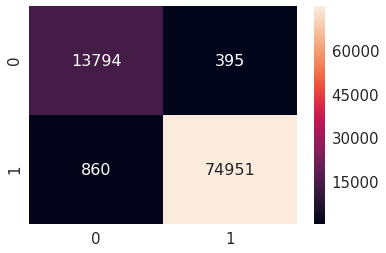

In [223]:
start = datetime.now()



clf = LogisticRegression(C= 100, penalty='l1', class_weight = 'balanced'); #best hyper-parameters
clf.fit(X_train_bow, Y_train);
Y_pred = clf.predict(X_test_bow)
w = clf.coef_
sparsity = np.mean(w.ravel()==0)*100
print('Sparsity is :' ,sparsity)
print('Non zero Weights :', np.count_nonzero(w))
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Macro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='macro')))
print("Micro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='micro')))
print("Weighted roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='weighted')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Log loss :",metrics.log_loss(Y_test,Y_pred))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Sparsity is : 0.0
Non zero Weights : 91213
Accuracy on test set: 97.507%
Macro F1-Score on test set: 0.955
Micro F1-Score on test set: 0.975
Weighted F1-Score on test set: 0.976
Macro roc_auc Score on test set: 0.975
Micro roc_auc Score on test set: 0.975
Weighted roc_auc Score on test set: 0.975
Precision on test set: 0.995
Recall on test set: 0.975
Error : 2.493%
Log loss : 0.8611700231694948
Precision recall report :
              precision    recall  f1-score   support

         -1       0.88      0.97      0.92     14189
          1       1.00      0.98      0.99     75811

avg / total       0.98      0.98      0.98     90000

TPR is 0.975148725119046
TNR is 0.9746282331383466
FPR is 0.025371766861653395
FNR is 0.024851274880953952

------------------------------------------------------------------------
Time taken to run this cell :
 0:00:32.044329
------------------------------------------------------------------------


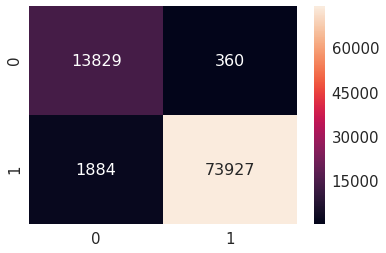

In [224]:
start = datetime.now()



clf = LogisticRegression(C= 100, penalty='l2', class_weight = 'balanced'); #best hyper-parameters
clf.fit(X_train_bow, Y_train);
Y_pred = clf.predict(X_test_bow)
w = clf.coef_
sparsity = np.mean(w.ravel()==0)*100
print('Sparsity is :' ,sparsity)
print('Non zero Weights :', np.count_nonzero(w))
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Macro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='macro')))
print("Micro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='micro')))
print("Weighted roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='weighted')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Log loss :",metrics.log_loss(Y_test,Y_pred))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

<h4> 2.1.2 Perturbation Test : </h4>



In [225]:
from scipy.sparse import find

In [226]:
X_train_random = X_train_bow
#Random noise
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_random)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_random)

#Introducing random noise to non-zero datapoints
X_train_random[a,b] = epsilon + X_train_random[a,b]


In [227]:
start = datetime.now()


clf1 = LogisticRegression(C= 100, penalty= 'l2')
clf1.fit(X_train_random,Y_train)
Y_pred = clf.predict(X_test_bow)
print('Sparsity is :' ,sparsity)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100))
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Log loss :",metrics.log_loss(Y_test,Y_pred))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Sparsity is : 0.0
Accuracy on test set: 97.507%
Macro F1-Score on test set: 0.955
Micro F1-Score on test set: 0.975
Weighted F1-Score on test set: 0.976
Log loss : 0.8611700231694948
Non Zero weights: 91213
Error : 2.493%

------------------------------------------------------------------------
Time taken to run this cell :
 0:00:23.109217
------------------------------------------------------------------------


In [229]:
all_feat = count_vect.get_feature_names()


In [230]:
def show_most_informative_features(vectorizer, clf, n= 25):
    feature_names = all_feat
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:(n + 1): -1], coefs_with_fns[:n])
    print("\t\tPositive\t\t\t\t\tNegative")
    print("_________________________________________________________________________________ \n")
    for (coef_1, fn_2), (coef_2, fn_1) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_2, coef_2, fn_1))
        


#Source : https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

In [231]:
show_most_informative_features(X_train_bow,clf)


		Positive					Negative
_________________________________________________________________________________ 

	33.8003	impati         				-43.4535	shipmentitem   
	32.1093	productenjoy   				-43.2657	podgot         
	31.7843	upsw           				-41.5107	tastknow       
	29.8639	donewell       				-39.2127	overprtea      
	26.1547	lovelove       				-38.8584	foodview       
	26.0013	policiprice    				-38.7662	lickship       
	25.9398	downsid        				-37.7924	oneundrink     
	25.8937	waylike        				-37.6076	donutrememb    
	25.8732	onegreat       				-36.2536	pricecarbquik  
	25.3847	popcornpopcorn 				-36.1998	valuthorough   
	25.2715	unsur          				-35.3939	finnish        
	25.0400	yesgreat       				-35.1464	pcs            
	24.6842	ripgreat       				-34.5653	marketamazon   
	24.6829	conposit       				-33.9946	treatwonder    
	24.6258	yummigreat     				-33.7071	disappointive  
	24.5945	thinglook      				-33.5976	decepthonest   
	24.5368	drawback       				-33.5408	hungrim

<h2> 2.2 RandomizedSearchCV: </h2>

In [200]:
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

In [201]:
start = datetime.now()


tuned_parameters = { 'C': [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4],
              'penalty':['l1','l2']}
model = RandomizedSearchCV(LogisticRegression(n_jobs = -1), tuned_parameters, cv = tscv,
                     scoring = 'f1', n_jobs = -1)
model.fit(X_train_bow, Y_train)
Y_pred = model.predict(X_test_bow)
print(model.best_estimator_)
print('Score with f1 is :',model.score(X_test_bow, Y_test))
print("Best HyperParameter for f1 scoring: ",model.best_params_)
print("Best Accuracy for f1 scoring: %.2f%%"%(model.best_score_*100))

print('------------------------------------------------------------------------\n')

print('------------------------------------------------------------------------')



model_roc_auc = RandomizedSearchCV(LogisticRegression(n_jobs = -1), tuned_parameters, cv = tscv,
                     scoring = 'roc_auc', n_jobs = -1)
model_roc_auc.fit(X_train_bow, Y_train)
Y_pred = model_roc_auc.predict(X_test_bow)
print(model_roc_auc.best_estimator_)
print('Score with roc_auc is :',model_roc_auc.score(X_test_bow, Y_test))
print("Best HyperParameter for roc_auc: ",model_roc_auc.best_params_)
print("Best Accuracy for roc_auc: %.2f%%"%(model_roc_auc.best_score_*100))

print('------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Score with f1 is : 0.9925615256785629
Best HyperParameter for f1 scoring:  {'penalty': 'l1', 'C': 10000}
Best Accuracy for f1 scoring: 97.73%
------------------------------------------------------------------------

------------------------------------------------------------------------
LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Score with roc_auc is : 0.9911374685758861
Best HyperParameter for roc_auc:  {'penalty': 'l2', 'C': 100}
Best Accuracy for roc_auc: 97.66%
--------------------------------------

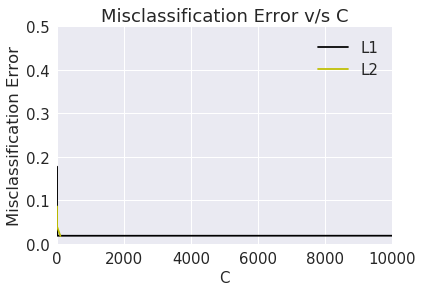

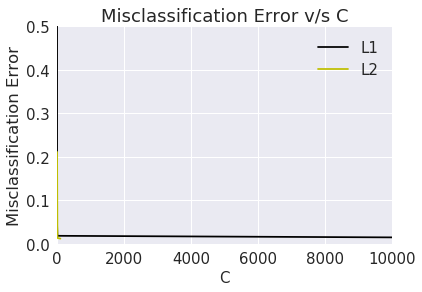

In [232]:
#Function to plot Misclassification error against C
def plot_error_vs_c_random(model):
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    for a in model.grid_scores_:
        if (a[0]['penalty']) == 'l1':
            y1.append(1-a[1])
            x1.append(a[0]['C'])
        else:
            y2.append(1-a[1])
            x2.append(a[0]['C'])

    ind1 = np.argsort(x1)
    x1=np.array(x1)
    y1=np.array(y1)
    ind2 = np.argsort(x2)
    x2=np.array(x2)
    y2=np.array(y2)
    plt.xlim(10**-4,10**4) # Limiting Values of tuned parameter 
    plt.ylim(0,0.5) #assuming maximum error would be 50%
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Misclassification Error")
    plt.title('Misclassification Error v/s C')
    plt.plot(x1[ind1],y1[ind1],'k',label="L1")
    plt.plot(x2[ind2],y2[ind2],'y',label="L2")
    plt.legend()
    plt.show()

plot_error_vs_c_random(model)
plot_error_vs_c_random(model_roc_auc)

<h3> 2.2.1 As per the f-1 scoring: </h3>


Sparsity is : 76.48580794404306
Non zero Weights : 21448
Accuracy on test set: 98.796%
Macro F1-Score on test set: 0.977
Micro F1-Score on test set: 0.988
Weighted F1-Score on test set: 0.988
Macro roc_auc Score on test set: 0.979
Micro roc_auc Score on test set: 0.979
Weighted roc_auc Score on test set: 0.979
Precision on test set: 0.993
Recall on test set: 0.992
Error : 1.204%
Log loss : 0.4160048245599533
Precision recall report :
              precision    recall  f1-score   support

         -1       0.96      0.96      0.96     14189
          1       0.99      0.99      0.99     75811

avg / total       0.99      0.99      0.99     90000

TPR is 0.9923098231127409
TNR is 0.964690957784199
FPR is 0.03530904221580097
FNR is 0.007690176887259105

------------------------------------------------------------------------
Time taken to run this cell :
 0:00:10.024802
------------------------------------------------------------------------


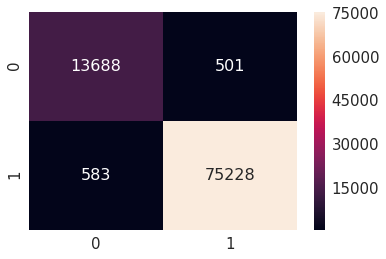

In [233]:
start = datetime.now()



clf = LogisticRegression(C= 10000, penalty='l1', class_weight = 'balanced'); #best hyper-parameters
clf.fit(X_train_bow, Y_train);
Y_pred = clf.predict(X_test_bow)
w = clf.coef_
sparsity = np.mean(w.ravel()==0)*100
print('Sparsity is :' ,sparsity)
print('Non zero Weights :', np.count_nonzero(w))
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Macro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='macro')))
print("Micro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='micro')))
print("Weighted roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='weighted')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Log loss :",metrics.log_loss(Y_test,Y_pred))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

<h3> 2.2.2 As per the roc_auc scoring: </h3>


Sparsity is : 0.0
Non zero Weights : 91213
Accuracy on test set: 97.508%
Macro F1-Score on test set: 0.955
Micro F1-Score on test set: 0.975
Weighted F1-Score on test set: 0.976
Macro roc_auc Score on test set: 0.975
Micro roc_auc Score on test set: 0.975
Weighted roc_auc Score on test set: 0.975
Precision on test set: 0.995
Recall on test set: 0.975
Error : 2.492%
Log loss : 0.8607862678717448
Precision recall report :
              precision    recall  f1-score   support

         -1       0.88      0.97      0.92     14189
          1       1.00      0.98      0.99     75811

avg / total       0.98      0.98      0.98     90000

TPR is 0.9751751065148857
TNR is 0.9745577560081754
FPR is 0.025442243991824653
FNR is 0.024824893485114297

------------------------------------------------------------------------
Time taken to run this cell :
 0:00:32.056051
------------------------------------------------------------------------


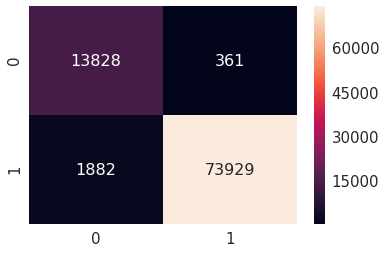

In [234]:
start = datetime.now()



clf = LogisticRegression(C= 100, penalty='l2', class_weight = 'balanced'); #best hyper-parameters
clf.fit(X_train_bow, Y_train);
Y_pred = clf.predict(X_test_bow)
w = clf.coef_
sparsity = np.mean(w.ravel()==0)*100
print('Sparsity is :' ,sparsity)
print('Non zero Weights :', np.count_nonzero(w))
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Macro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='macro')))
print("Micro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='micro')))
print("Weighted roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='weighted')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Log loss :",metrics.log_loss(Y_test,Y_pred))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

<h3> 2.2.3 Peterburation Test: </h3>


In [235]:
X_train_random = X_train_bow
#Random noise
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_random)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_random)

#Introducing random noise to non-zero datapoints
X_train_random[a,b] = epsilon + X_train_random[a,b]

In [236]:
start = datetime.now()


clf1 = LogisticRegression(C= 100, penalty= 'l2')
clf1.fit(X_train_random,Y_train)
Y_pred = clf.predict(X_test_bow)
print('Sparsity is :' ,sparsity)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100))
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Log loss :",metrics.log_loss(Y_test,Y_pred))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Sparsity is : 0.0
Accuracy on test set: 97.508%
Macro F1-Score on test set: 0.955
Micro F1-Score on test set: 0.975
Weighted F1-Score on test set: 0.976
Log loss : 0.8607862678717448
Non Zero weights: 91213
Error : 2.492%

------------------------------------------------------------------------
Time taken to run this cell :
 0:00:24.414517
------------------------------------------------------------------------


In [237]:
show_most_informative_features(X_train_bow,clf1)

		Positive					Negative
_________________________________________________________________________________ 

	32.8521	ripgreat       				-37.0834	tastknow       
	32.5355	impati         				-37.0645	shipmentitem   
	32.0067	productenjoy   				-36.0257	podgot         
	26.9159	websitceltic   				-34.4162	oneundrink     
	26.5956	donewell       				-34.1300	foodview       
	25.7015	upsw           				-32.7081	valuthorough   
	25.4041	seemmust       				-32.4241	donutrememb    
	24.8394	policiprice    				-32.0736	pricecarbquik  
	24.4653	likemight      				-31.5444	pcs            
	23.8461	waylike        				-30.8382	finnish        
	23.6452	conposit       				-30.3088	lickship       
	23.5140	onegreat       				-29.2352	decepthonest   
	23.4688	dentdont       				-29.0186	hungrimade     
	23.4017	lovelove       				-28.9144	chihuahuawant  
	23.1064	popcornpopcorn 				-28.1898	crireturn      
	22.8285	downsid        				-28.0243	ricewant       
	22.7493	blendcompait   				-27.6953	treatwo

<h1> 3.Term frequency & Inverse document frequency </h1>


In [208]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train_tf = tf_idf_vect.fit_transform(X_train.values)
X_test_tf = tf_idf_vect.transform(X_test)
print("the type of count vectorizer ",type(X_train_tf))
print("the shape of out text TFIDF vectorizer ",X_train_tf.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_tf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (210000, 1355449)
the number of unique words including both unigrams and bigrams  1355449


In [209]:
X_train_tf = preprocessing.normalize(X_train_tf)
X_train_tf

<210000x1355449 sparse matrix of type '<class 'numpy.float64'>'
	with 14870021 stored elements in Compressed Sparse Row format>

In [210]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train_tf):
    print(X_train_tf[train].shape, X_train_tf[cv].shape)


(19100, 1355449) (19090, 1355449)
(38190, 1355449) (19090, 1355449)
(57280, 1355449) (19090, 1355449)
(76370, 1355449) (19090, 1355449)
(95460, 1355449) (19090, 1355449)
(114550, 1355449) (19090, 1355449)
(133640, 1355449) (19090, 1355449)
(152730, 1355449) (19090, 1355449)
(171820, 1355449) (19090, 1355449)
(190910, 1355449) (19090, 1355449)


<h2> 3.1 Grid Search </h2>

In [211]:
start = datetime.now()


tuned_parameters = { 'C': [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4],
              'penalty':['l1','l2']}
model = RandomizedSearchCV(LogisticRegression(n_jobs = -1), tuned_parameters, cv = tscv,
                     scoring = 'f1', n_jobs = -1)
model.fit(X_train_tf, Y_train)
Y_pred = model.predict(X_test_tf)
print(model.best_estimator_)
print('Score with f1 is :',model.score(X_test_tf, Y_test))
print("Best HyperParameter for f1 scoring: ",model.best_params_)
print("Best Accuracy for f1 scoring: %.2f%%"%(model.best_score_*100))

print('------------------------------------------------------------------------\n')

print('------------------------------------------------------------------------')



model_roc_auc = RandomizedSearchCV(LogisticRegression(n_jobs = -1), tuned_parameters, cv = tscv,
                     scoring = 'roc_auc', n_jobs = -1)
model_roc_auc.fit(X_train_tf, Y_train)
Y_pred = model_roc_auc.predict(X_test_tf)
print(model_roc_auc.best_estimator_)
print('Score with roc_auc is :',model_roc_auc.score(X_test_tf, Y_test))
print("Best HyperParameter for roc_auc: ",model_roc_auc.best_params_)
print("Best Accuracy for roc_auc: %.2f%%"%(model_roc_auc.best_score_*100))

print('------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Score with f1 is : 0.9952734549859126
Best HyperParameter for f1 scoring:  {'penalty': 'l2', 'C': 10000}
Best Accuracy for f1 scoring: 98.26%
------------------------------------------------------------------------

------------------------------------------------------------------------
LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Score with roc_auc is : 0.9979677028778122
Best HyperParameter for roc_auc:  {'penalty': 'l2', 'C': 10000}
Best Accuracy for roc_auc: 98.85%
----------------------------------

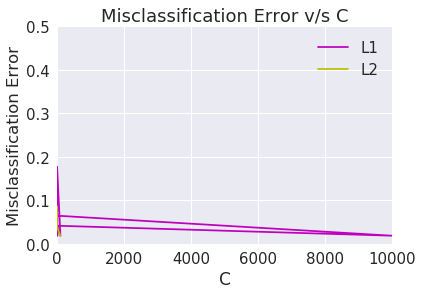

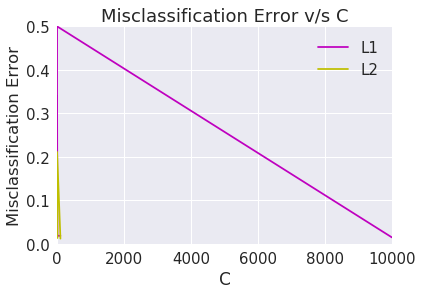

In [238]:
plot_error_vs_c(model)
plot_error_vs_c(model_roc_auc)

Sparsity is : 0.0
Non zero Weights : 1355449
Accuracy on test set: 99.224%
Macro F1-Score on test set: 0.985
Micro F1-Score on test set: 0.992
Weighted F1-Score on test set: 0.992
Macro roc_auc Score on test set: 0.983
Micro roc_auc Score on test set: 0.983
Weighted roc_auc Score on test set: 0.983
Precision on test set: 0.995
Recall on test set: 0.996
Error : 0.776%
Log loss : 0.2678711039530682
Precision recall report :
              precision    recall  f1-score   support

         -1       0.98      0.97      0.98     14189
          1       0.99      1.00      1.00     75811

avg / total       0.99      0.99      0.99     90000

TPR is 0.9962934138845286
TNR is 0.9706110367185848
FPR is 0.02938896328141518
FNR is 0.0037065861154713694

------------------------------------------------------------------------
Time taken to run this cell :
 0:00:40.433049
------------------------------------------------------------------------


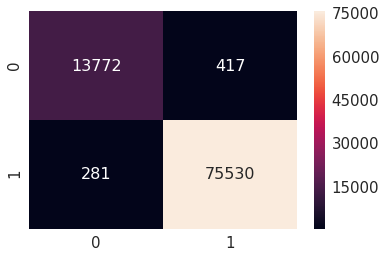

In [239]:
start = datetime.now()



clf = LogisticRegression(C= 10000, penalty='l2', class_weight = 'balanced'); #best hyper-parameters
clf.fit(X_train_tf, Y_train);
Y_pred = clf.predict(X_test_tf)
w = clf.coef_
sparsity = np.mean(w.ravel()==0)*100
print('Sparsity is :' ,sparsity)
print('Non zero Weights :', np.count_nonzero(w))
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Macro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='macro')))
print("Micro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='micro')))
print("Weighted roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='weighted')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Log loss :",metrics.log_loss(Y_test,Y_pred))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

<h3> 3.1.1 Peterburation Test: </h3>


In [240]:
X_train_random = X_train_tf
#Random noise
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_random)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_random)

#Introducing random noise to non-zero datapoints
X_train_random[a,b] = epsilon + X_train_random[a,b]


In [241]:
start = datetime.now()


clf1 = LogisticRegression(C= 10000, penalty= 'l2')
clf1.fit(X_train_random,Y_train)
Y_pred = clf.predict(X_test_tf)
print('Sparsity is :' ,sparsity)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100))
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Log loss :",metrics.log_loss(Y_test,Y_pred))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Sparsity is : 0.0
Accuracy on test set: 99.224%
Macro F1-Score on test set: 0.985
Micro F1-Score on test set: 0.992
Weighted F1-Score on test set: 0.992
Log loss : 0.2678711039530682
Non Zero weights: 1355449
Error : 0.776%

------------------------------------------------------------------------
Time taken to run this cell :
 0:00:26.538896
------------------------------------------------------------------------


<h3> 3.1.2 Important Words: </h3>


In [242]:
show_most_informative_features(X_train_tf,clf)

		Positive					Negative
_________________________________________________________________________________ 

	38.4261	sauchunt       				-36.7181	ricealway      
	36.3554	geesh          				-28.7966	starterbeauti  
	34.1052	brightadmit    				-17.0561	productbob     
	16.9129	francbeliev    				-15.2155	usequaliti     
	16.3610	farro          				-14.7818	rost           
	15.8869	greatisnt      				-14.2126	paolo          
	15.4318	lishlove       				-12.9679	insomniacsinc  
	14.6633	filer          				-12.8557	mammapurchas   
	14.3675	much           				-12.4593	yetglad        
	14.1008	ali            				-12.3229	expectlollipop 
	14.0965	boiardi        				-11.4655	reshop         
	13.5153	citrat         				-11.2961	stawberri      
	12.8686	bagelsomeon    				-11.0668	regen          
	12.7188	raisonfeel     				-10.8836	aromaexcit     
	11.5457	gravilike      				-10.7879	teacoupl       
	11.3303	findorigin     				-10.6969	poorpeopl      
	11.1536	stuffperson    				-10.6750	szege  

<h2> 3.2 Randomized search CV: </h2>

In [218]:
start = datetime.now()


tuned_parameters = { 'C': [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4],
              'penalty':['l1','l2']}
model = RandomizedSearchCV(LogisticRegression(n_jobs = -1), tuned_parameters, cv = tscv,
                     scoring = 'f1', n_jobs = -1)
model.fit(X_train_tf, Y_train)
Y_pred = model.predict(X_test_tf)
print(model.best_estimator_)
print('Score with f1 is :',model.score(X_test_tf, Y_test))
print("Best HyperParameter for f1 scoring: ",model.best_params_)
print("Best Accuracy for f1 scoring: %.2f%%"%(model.best_score_*100))

print('------------------------------------------------------------------------\n')

print('------------------------------------------------------------------------')



model_roc_auc = RandomizedSearchCV(LogisticRegression(n_jobs = -1), tuned_parameters, 
                                   cv = tscv, scoring = 'roc_auc', n_jobs = -1)
model_roc_auc.fit(X_train_tf, Y_train)
Y_pred = model_roc_auc.predict(X_test_tf)
print(model_roc_auc.best_estimator_)
print('Score with roc_auc is :',model_roc_auc.score(X_test_tf, Y_test))
print("Best HyperParameter for roc_auc: ",model_roc_auc.best_params_)
print("Best Accuracy for roc_auc: %.2f%%"%(model_roc_auc.best_score_*100))

print('------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Score with f1 is : 0.9952612873502698
Best HyperParameter for f1 scoring:  {'penalty': 'l2', 'C': 100}
Best Accuracy for f1 scoring: 98.22%
------------------------------------------------------------------------

------------------------------------------------------------------------
LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Score with roc_auc is : 0.9977349073722167
Best HyperParameter for roc_auc:  {'penalty': 'l2', 'C': 100}
Best Accuracy for roc_auc: 98.81%
------------------------------------------

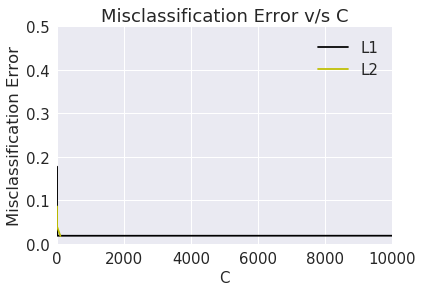

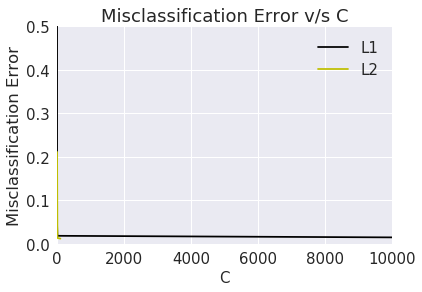

In [219]:
plot_error_vs_c_random(model)
plot_error_vs_c_random(model_roc_auc)

Sparsity is : 0.0
Non zero Weights : 1355449
Accuracy on test set: 99.237%
Macro F1-Score on test set: 0.986
Micro F1-Score on test set: 0.992
Weighted F1-Score on test set: 0.992
Macro roc_auc Score on test set: 0.985
Micro roc_auc Score on test set: 0.985
Weighted roc_auc Score on test set: 0.985
Precision on test set: 0.995
Recall on test set: 0.996
Error : 0.763%
Log loss : 0.2636493336881942
Precision recall report :
              precision    recall  f1-score   support

         -1       0.98      0.97      0.98     14189
          1       1.00      1.00      1.00     75811

avg / total       0.99      0.99      0.99     90000

TPR is 0.9958976929469339
TNR is 0.9735005990556065
FPR is 0.026499400944393545
FNR is 0.004102307053066178

------------------------------------------------------------------------
Time taken to run this cell :
 0:00:38.059580
------------------------------------------------------------------------


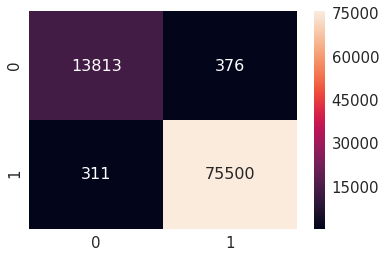

In [243]:
start = datetime.now()



clf = LogisticRegression(C= 100, penalty='l2', class_weight = 'balanced'); #best hyper-parameters
clf.fit(X_train_tf, Y_train);
Y_pred = clf.predict(X_test_tf)
w = clf.coef_
sparsity = np.mean(w.ravel()==0)*100
print('Sparsity is :' ,sparsity)
print('Non zero Weights :', np.count_nonzero(w))
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Macro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='macro')))
print("Micro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='micro')))
print("Weighted roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='weighted')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Log loss :",metrics.log_loss(Y_test,Y_pred))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

<h3> 3.2.1 Peterburation test: </h3>


In [244]:
X_train_random = X_train_tf
#Random noise
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_random)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_random)

#Introducing random noise to non-zero datapoints
X_train_random[a,b] = epsilon + X_train_random[a,b]

In [245]:
start = datetime.now()


clf1 = LogisticRegression(C= 100, penalty= 'l2')
clf1.fit(X_train_random,Y_train)
Y_pred = clf.predict(X_test_tf)
print('Sparsity is :' ,sparsity)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100))
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Log loss :",metrics.log_loss(Y_test,Y_pred))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Sparsity is : 0.0
Accuracy on test set: 99.237%
Macro F1-Score on test set: 0.986
Micro F1-Score on test set: 0.992
Weighted F1-Score on test set: 0.992
Log loss : 0.2636493336881942
Non Zero weights: 1355449
Error : 0.763%

------------------------------------------------------------------------
Time taken to run this cell :
 0:00:19.735343
------------------------------------------------------------------------


<h3> 3.2.2 Important Words: </h3>

In [246]:
show_most_informative_features(X,clf1)

		Positive					Negative
_________________________________________________________________________________ 

	22.1598	sauchunt       				-22.9226	ricealway      
	21.1054	geesh          				-17.3464	starterbeauti  
	19.6163	brightadmit    				-9.6390	rost           
	10.3611	francbeliev    				-9.3452	productbob     
	9.3335	boiardi        				-9.1993	usequaliti     
	8.8738	farro          				-8.0990	paolo          
	8.4351	lishlove       				-7.3280	mammapurchas   
	8.2832	greatisnt      				-7.0834	insomniacsinc  
	8.1451	much           				-6.6551	reshop         
	7.9946	filer          				-6.6124	expectlollipop 
	7.6531	citrat         				-6.5113	coffewow       
	7.6106	raisonfeel     				-6.4606	yetglad        
	7.5647	ali            				-6.2497	poorpeopl      
	7.1706	bagelsomeon    				-5.9052	aromaexcit     
	6.5081	findorigin     				-5.8900	regen          
	5.8889	bestnoth       				-5.8524	sonbetter      
	5.8175	acoupl         				-5.7726	teacoupl       
	5.6462	stuffperson

<h1>  4. Word to vec: </h1>


This technique takes the semantic meaning if word into consideration. It is very simple. Just give it a word and you will get the vector of d-dimension. If two words are similar, Then the correspondin vectors seem to be closer. For example (Vman - Vwoman) || (Vking - vqueen) It learns all relatiomships without being programmed. The more the dimensions, the larger the dimensionality. we need large data to execute it. What is basically does is, it looks at the neighbourhood for similarity.



In [248]:

i=0
list_of_sent=[]
for sent in X_train.values:
    list_of_sent.append(sent.split())


In [249]:

print(X_train.values[0])
print("*****************************************************************")
print(list_of_sent[0])




love cofferealli enjoy keurig coffe maker coffe disappoint strong smooth carmal flavor like use ice brew make latt home
*****************************************************************
['love', 'cofferealli', 'enjoy', 'keurig', 'coffe', 'maker', 'coffe', 'disappoint', 'strong', 'smooth', 'carmal', 'flavor', 'like', 'use', 'ice', 'brew', 'make', 'latt', 'home']


In [252]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [253]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  28918
sample words  ['love', 'cofferealli', 'enjoy', 'keurig', 'coffe', 'maker', 'disappoint', 'strong', 'smooth', 'carmal', 'flavor', 'like', 'use', 'ice', 'brew', 'make', 'latt', 'home', 'dog', 'attest', 'person', 'experi', 'teacup', 'yorkshir', 'crazi', 'chew', 'strip', 'theyr', 'fussi', 'newbi', 'cook', 'miss', 'came', 'meat', 'broth', 'product', 'chicken', 'pork', 'veget', 'bouillon', 'wonder', 'get', 'ship', 'right', 'door', 'amazon', 'store', 'search', 'obscur', 'vegan']


<h2> 4.1 Average W2V: </h2>


It is basically used for converting sentences to vectors. It takes w2v of different words and adds them, then dividing them by the no of words. It is most proably the simplest way to build a sentence vector.


In [254]:

from tqdm import tqdm

In [255]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 210000/210000 [09:48<00:00, 357.10it/s]

210000
50


<h3> 4.1.1 Grid search </h3>

In [258]:
X_train_wv = sent_vectors
X_train_wv = preprocessing.normalize(X_train_wv)
X_train_wv

array([[ 0.17795661,  0.14425901, -0.04719536, ...,  0.05941104,
        -0.11685521, -0.05051593],
       [-0.02111261,  0.08632243, -0.05891713, ...,  0.26546436,
        -0.01987572, -0.17373413],
       [ 0.35281148,  0.04244067, -0.23230923, ...,  0.01836627,
         0.06197005,  0.09123449],
       ...,
       [ 0.19035748, -0.04458668, -0.16202549, ...,  0.12759574,
         0.13080343, -0.06066861],
       [ 0.10068023,  0.16732305, -0.1811736 , ..., -0.07314796,
        -0.03440067, -0.15852808],
       [ 0.23495133,  0.03004477, -0.03320304, ...,  0.01047419,
         0.18383945, -0.06918988]])

In [260]:
start = datetime.now()

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

tuned_parameters = { 'C': [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4],
              'penalty':['l1','l2']}
model = GridSearchCV(LogisticRegression(n_jobs = -1), tuned_parameters, cv = tscv,
                     scoring = 'f1', n_jobs = -1)
model.fit(X_train_wv, Y_train)
print(model.best_estimator_)
print("Best HyperParameter for f1 scoring: ",model.best_params_)
print("Best Accuracy for f1 scoring: %.2f%%"%(model.best_score_*100))

print('------------------------------------------------------------------------\n')

print('------------------------------------------------------------------------')



model_roc_auc = GridSearchCV(LogisticRegression(n_jobs = -1), tuned_parameters, cv = tscv,
                     scoring = 'roc_auc', n_jobs = -1)
model_roc_auc.fit(X_train_wv, Y_train)
print(model_roc_auc.best_estimator_)
print("Best HyperParameter for roc_auc: ",model_roc_auc.best_params_)
print("Best Accuracy for roc_auc: %.2f%%"%(model_roc_auc.best_score_*100))

print('------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Best HyperParameter for f1 scoring:  {'C': 1, 'penalty': 'l1'}
Best Accuracy for f1 scoring: 94.38%
------------------------------------------------------------------------

------------------------------------------------------------------------
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Best HyperParameter for roc_auc:  {'C': 10, 'penalty': 'l2'}
Best Accuracy for roc_auc: 92.55%
------------------------------------------------------------------------
Time taken to run this cell :
 0:11:55.028399
----------

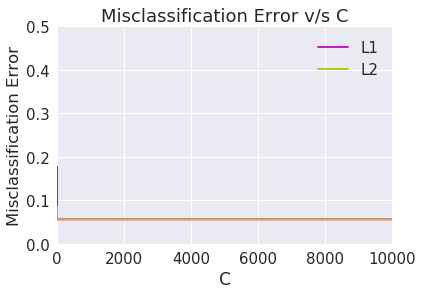

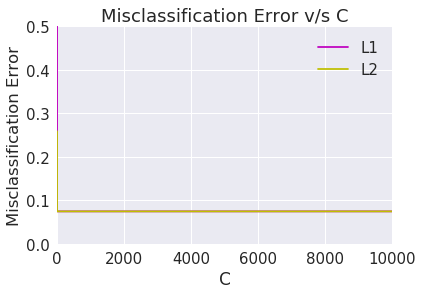

In [261]:
plot_error_vs_c(model)
plot_error_vs_c(model_roc_auc)

<h3> 4.1.2 Random search: </h3>

In [262]:

start = datetime.now()



tuned_parameters = { 'C': [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4],
              'penalty':['l1','l2']}
model =RandomizedSearchCV(LogisticRegression(n_jobs = -1), tuned_parameters, cv = tscv,
                     scoring = 'f1', n_jobs = -1)
model.fit(X_train_wv, Y_train)
print(model.best_estimator_)
print("Best HyperParameter for f1 scoring: ",model.best_params_)
print("Best Accuracy for f1 scoring: %.2f%%"%(model.best_score_*100))

print('------------------------------------------------------------------------\n')

print('------------------------------------------------------------------------')



model_roc_auc = GridSearchCV(LogisticRegression(n_jobs = -1), tuned_parameters, cv = tscv,
                     scoring = 'roc_auc', n_jobs = -1)
model_roc_auc.fit(X_train_wv, Y_train)
print(model_roc_auc.best_estimator_)
print("Best HyperParameter for roc_auc: ",model_roc_auc.best_params_)
print("Best Accuracy for roc_auc: %.2f%%"%(model_roc_auc.best_score_*100))

print('------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Best HyperParameter for f1 scoring:  {'penalty': 'l1', 'C': 1}
Best Accuracy for f1 scoring: 94.38%
------------------------------------------------------------------------

------------------------------------------------------------------------
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Best HyperParameter for roc_auc:  {'C': 10, 'penalty': 'l2'}
Best Accuracy for roc_auc: 92.55%
------------------------------------------------------------------------
Time taken to run this cell :
 0:10:30.889621
----------

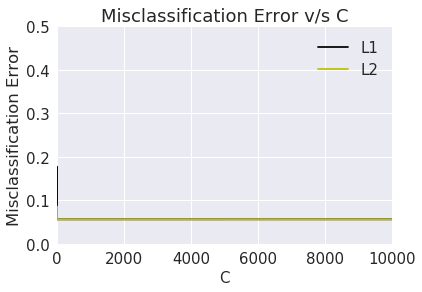

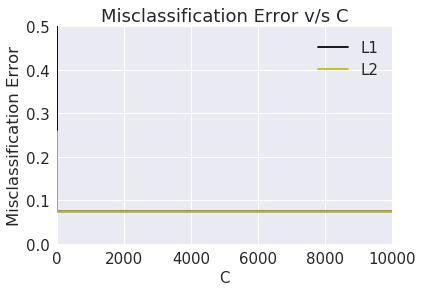

In [263]:
plot_error_vs_c_random(model)
plot_error_vs_c_random(model_roc_auc)

<h1> 5. TF-IDF weighted Word2Vec: </h1>




In [264]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [265]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 210000/210000 [10:27<00:00, 334.57it/s]


In [266]:
tfidf_sent_vectors = preprocessing.normalize(tfidf_sent_vectors)
print(tfidf_sent_vectors.shape)

(210000, 50)


In [267]:
X_train_twv = tfidf_sent_vectors



<h2> 5.1 Gridsearch </h2>

In [268]:
start = datetime.now()

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

tuned_parameters = { 'C': [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4],
              'penalty':['l1','l2']}
model = GridSearchCV(LogisticRegression(n_jobs = -1), tuned_parameters, cv = tscv,
                     scoring = 'f1', n_jobs = -1)
model.fit(X_train_twv, Y_train)
print(model.best_estimator_)
print("Best HyperParameter for f1 scoring: ",model.best_params_)
print("Best Accuracy for f1 scoring: %.2f%%"%(model.best_score_*100))

print('------------------------------------------------------------------------\n')

print('------------------------------------------------------------------------')



model_roc_auc = GridSearchCV(LogisticRegression(n_jobs = -1), tuned_parameters, cv = tscv,
                     scoring = 'roc_auc', n_jobs = -1)
model_roc_auc.fit(X_train_twv, Y_train)
print(model_roc_auc.best_estimator_)
print("Best HyperParameter for roc_auc: ",model_roc_auc.best_params_)
print("Best Accuracy for roc_auc: %.2f%%"%(model_roc_auc.best_score_*100))

print('------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Best HyperParameter for f1 scoring:  {'C': 1, 'penalty': 'l1'}
Best Accuracy for f1 scoring: 93.58%
------------------------------------------------------------------------

------------------------------------------------------------------------
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Best HyperParameter for roc_auc:  {'C': 10, 'penalty': 'l2'}
Best Accuracy for roc_auc: 89.97%
------------------------------------------------------------------------
Time taken to run this cell :
 0:11:33.155773
----------

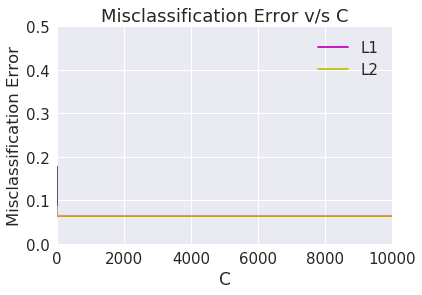

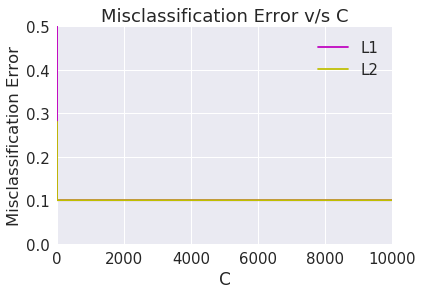

In [269]:
plot_error_vs_c(model)
plot_error_vs_c(model_roc_auc)

<h2> 5.2 RandomSearch: </h2>

In [270]:
start = datetime.now()

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

tuned_parameters = { 'C': [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4],
              'penalty':['l1','l2']}
model =RandomizedSearchCV(LogisticRegression(n_jobs = -1), tuned_parameters, cv = tscv,
                     scoring = 'f1', n_jobs = -1)
model.fit(X_train_twv, Y_train)
print(model.best_estimator_)
print("Best HyperParameter for f1 scoring: ",model.best_params_)
print("Best Accuracy for f1 scoring: %.2f%%"%(model.best_score_*100))

print('------------------------------------------------------------------------\n')

print('------------------------------------------------------------------------')



model_roc_auc = GridSearchCV(LogisticRegression(n_jobs = -1), tuned_parameters, cv = tscv,
                     scoring = 'roc_auc', n_jobs = -1)
model_roc_auc.fit(X_train_twv, Y_train)
print(model_roc_auc.best_estimator_)
print("Best HyperParameter for roc_auc: ",model_roc_auc.best_params_)
print("Best Accuracy for roc_auc: %.2f%%"%(model_roc_auc.best_score_*100))

print('------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Best HyperParameter for f1 scoring:  {'penalty': 'l2', 'C': 10}
Best Accuracy for f1 scoring: 93.58%
------------------------------------------------------------------------

------------------------------------------------------------------------
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Best HyperParameter for roc_auc:  {'C': 10, 'penalty': 'l1'}
Best Accuracy for roc_auc: 89.97%
------------------------------------------------------------------------
Time taken to run this cell :
 0:08:37.435359
--------

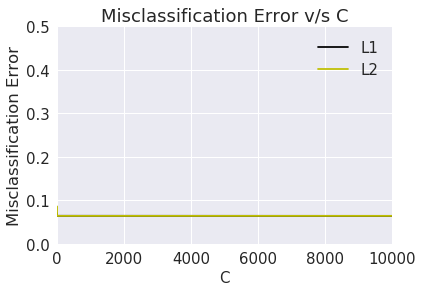

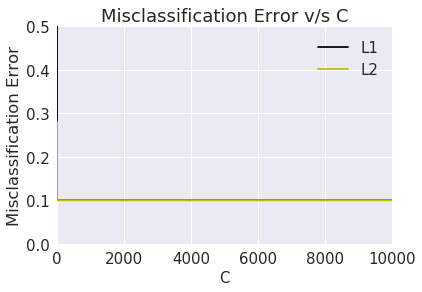

In [271]:
plot_error_vs_c_random(model)
plot_error_vs_c_random(model_roc_auc)

<h1> 6. Test W2V & predict: </6>


In [272]:
i=0
list_of_sent=[]
for sent in X_test.values:
    list_of_sent.append(sent.split())

In [273]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 90000/90000 [04:44<00:00, 316.33it/s]

90000
50


In [274]:
X_test_wv = sent_vectors
X_test_wv = preprocessing.normalize(X_test_wv)

Sparsity is : 0.0
Non zero Weights : 50
Accuracy on test set: 84.533%
Macro F1-Score on test set: 0.769
Micro F1-Score on test set: 0.845
Weighted F1-Score on test set: 0.860
Macro roc_auc Score on test set: 0.850
Micro roc_auc Score on test set: 0.850
Weighted roc_auc Score on test set: 0.850
Precision on test set: 0.969
Recall on test set: 0.843
Error : 15.467%
Log loss : 5.3420154777636935
Precision recall report :
              precision    recall  f1-score   support

         -1       0.51      0.86      0.64     14189
          1       0.97      0.84      0.90     75811

avg / total       0.90      0.85      0.86     90000

TPR is 0.8432021738270172
TNR is 0.8567199943618296
FPR is 0.14328000563817042
FNR is 0.15679782617298282

------------------------------------------------------------------------
Time taken to run this cell :
 0:00:23.607672
------------------------------------------------------------------------


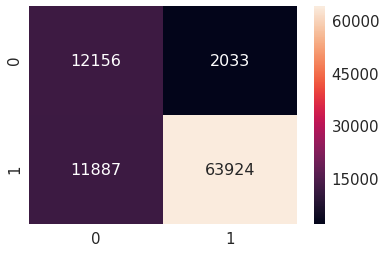

In [276]:
start = datetime.now()

#on f1

clf = LogisticRegression(C= 1, penalty='l1', class_weight = 'balanced'); #best hyper-parameters
clf.fit(X_train_wv, Y_train);
Y_pred = clf.predict(X_test_wv)
w = clf.coef_
sparsity = np.mean(w.ravel()==0)*100
print('Sparsity is :' ,sparsity)
print('Non zero Weights :', np.count_nonzero(w))
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Macro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='macro')))
print("Micro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='micro')))
print("Weighted roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='weighted')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Log loss :",metrics.log_loss(Y_test,Y_pred))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Sparsity is : 0.0
Non zero Weights : 50
Accuracy on test set: 84.519%
Macro F1-Score on test set: 0.769
Micro F1-Score on test set: 0.845
Weighted F1-Score on test set: 0.860
Macro roc_auc Score on test set: 0.850
Micro roc_auc Score on test set: 0.850
Weighted roc_auc Score on test set: 0.850
Precision on test set: 0.969
Recall on test set: 0.843
Error : 15.481%
Log loss : 5.347004438785094
Precision recall report :
              precision    recall  f1-score   support

         -1       0.51      0.86      0.64     14189
          1       0.97      0.84      0.90     75811

avg / total       0.90      0.85      0.86     90000

TPR is 0.8430702668478189
TNR is 0.8565085629713158
FPR is 0.1434914370286842
FNR is 0.1569297331521811

------------------------------------------------------------------------
Time taken to run this cell :
 0:00:03.230787
------------------------------------------------------------------------


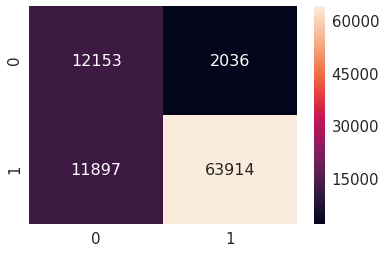

In [277]:
start = datetime.now()

#on roc_auc

clf = LogisticRegression(C= 10, penalty='l2', class_weight = 'balanced'); #best hyper-parameters
clf.fit(X_train_wv, Y_train);
Y_pred = clf.predict(X_test_wv)
w = clf.coef_
sparsity = np.mean(w.ravel()==0)*100
print('Sparsity is :' ,sparsity)
print('Non zero Weights :', np.count_nonzero(w))
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Macro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='macro')))
print("Micro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='micro')))
print("Weighted roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='weighted')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Log loss :",metrics.log_loss(Y_test,Y_pred))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

<h1> 7. Tfidf Test & predict: </h1>

In [278]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_test.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [279]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 90000/90000 [05:05<00:00, 294.50it/s]


In [280]:
X_test_twv = tfidf_sent_vectors
X_test_twv = preprocessing.normalize(X_test_twv)

Sparsity is : 0.0
Non zero Weights : 50
Accuracy on test set: 81.690%
Macro F1-Score on test set: 0.734
Micro F1-Score on test set: 0.817
Weighted F1-Score on test set: 0.836
Macro roc_auc Score on test set: 0.819
Micro roc_auc Score on test set: 0.819
Weighted roc_auc Score on test set: 0.819
Precision on test set: 0.961
Recall on test set: 0.816
Error : 18.310%
Log loss : 6.324072355520608
Precision recall report :
              precision    recall  f1-score   support

         -1       0.46      0.82      0.59     14189
          1       0.96      0.82      0.88     75811

avg / total       0.88      0.82      0.84     90000

TPR is 0.8158842384350556
TNR is 0.822327154838255
FPR is 0.177672845161745
FNR is 0.1841157615649444

------------------------------------------------------------------------
Time taken to run this cell :
 0:00:03.190403
------------------------------------------------------------------------


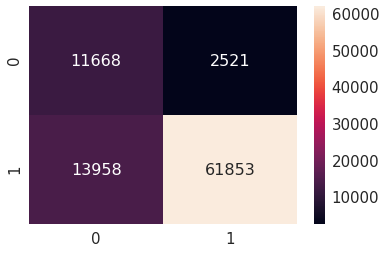

In [281]:
start = datetime.now()

#on roc_auc

clf = LogisticRegression(C= 10, penalty='l2', class_weight = 'balanced'); #best hyper-parameters
clf.fit(X_train_twv, Y_train);
Y_pred = clf.predict(X_test_twv)
w = clf.coef_
sparsity = np.mean(w.ravel()==0)*100
print('Sparsity is :' ,sparsity)
print('Non zero Weights :', np.count_nonzero(w))
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Macro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='macro')))
print("Micro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='micro')))
print("Weighted roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='weighted')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Log loss :",metrics.log_loss(Y_test,Y_pred))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Sparsity is : 0.0
Non zero Weights : 50
Accuracy on test set: 81.687%
Macro F1-Score on test set: 0.734
Micro F1-Score on test set: 0.817
Weighted F1-Score on test set: 0.836
Macro roc_auc Score on test set: 0.819
Micro roc_auc Score on test set: 0.819
Weighted roc_auc Score on test set: 0.819
Precision on test set: 0.961
Recall on test set: 0.816
Error : 18.313%
Log loss : 6.325223648067104
Precision recall report :
              precision    recall  f1-score   support

         -1       0.46      0.82      0.59     14189
          1       0.96      0.82      0.88     75811

avg / total       0.88      0.82      0.84     90000

TPR is 0.8158446663412962
TNR is 0.822327154838255
FPR is 0.177672845161745
FNR is 0.18415533365870387

------------------------------------------------------------------------
Time taken to run this cell :
 0:00:15.740370
------------------------------------------------------------------------


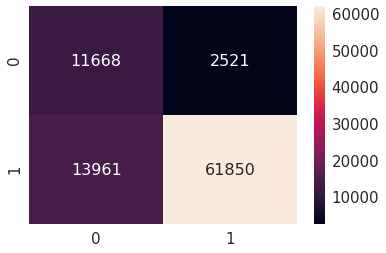

In [282]:
start = datetime.now()

#on roc_auc

clf = LogisticRegression(C= 10, penalty='l1', class_weight = 'balanced'); #best hyper-parameters
clf.fit(X_train_twv, Y_train);
Y_pred = clf.predict(X_test_twv)
w = clf.coef_
sparsity = np.mean(w.ravel()==0)*100
print('Sparsity is :' ,sparsity)
print('Non zero Weights :', np.count_nonzero(w))
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Macro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='macro')))
print("Micro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='micro')))
print("Weighted roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='weighted')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Log loss :",metrics.log_loss(Y_test,Y_pred))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

<h1> 8. Summary: </h1>

In [299]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["S.R","Vec", "Reg",'C', "Micro f-1", "Weighted f-1", 'roc_auc', 'Log-Loss']

x.add_row([(1),"BOW", "l2", 100, 0.975, 0.976, 0.975, 0.861])
x.add_row([(2),"TF-IDF", "l2", 10000, 0.992, 0.992, 0.983, 0.267])
x.add_row([(3),"W2v", "l2", 10, 0.845, 0.860, 0.850, 5.34])
x.add_row([(4),"TF-IDF wgh W2V", "l2", 10, 0.817, 0.836, 0.819, 6.32])



print(x.get_string(title = "-----GRID SEARCH-----"))


y = PrettyTable()

y.field_names = ["S.R","Vec", "Reg",'C', "Micro f-1", "Weighted f-1", 'roc_auc', 'Log-Loss']

y.add_row([(1),"BOW", "l2", 100, 0.975, 0.976, 0.975, 0.861])
y.add_row([(2),"TF-IDF", "l2", 100, 0.992, 0.992, 0.985, 0.263])
y.add_row([(3),"W2v", "l2", 10, 0.845, 0.860, 0.850, 5.34])
y.add_row([(4),"TF-IDF wgh W2V", "l2", 10, 0.817, 0.836, 0.819, 6.32])



print(y.get_string(title = "-----------------RANDOM SEARCH-----------------"))

+------------------------------------------------------------------------------------+
|                               -----GRID SEARCH-----                                |
+-----+----------------+-----+-------+-----------+--------------+---------+----------+
| S.R |      Vec       | Reg |   C   | Micro f-1 | Weighted f-1 | roc_auc | Log-Loss |
+-----+----------------+-----+-------+-----------+--------------+---------+----------+
|  1  |      BOW       |  l2 |  100  |   0.975   |    0.976     |  0.975  |  0.861   |
|  2  |     TF-IDF     |  l2 | 10000 |   0.992   |    0.992     |  0.983  |  0.267   |
|  3  |      W2v       |  l2 |   10  |   0.845   |     0.86     |   0.85  |   5.34   |
|  4  | TF-IDF wgh W2V |  l2 |   10  |   0.817   |    0.836     |  0.819  |   6.32   |
+-----+----------------+-----+-------+-----------+--------------+---------+----------+
+----------------------------------------------------------------------------------+
|                 -----------------RANDOM SEA